# Visualization of performance of models in each of the tasks

In [11]:
import os

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import font_manager as fm
from pathlib import Path

In [12]:
# Function definitions
def read_in_data_cube(base_path: str = "./auc_roc_scores/data", filename: str = "auc_roc_tensors_dict.npz") -> dict[str:np.ndarray]:
    """Read in the numpy array given a base path, the dataset_id, and the error_rate."""
    path = os.path.join(base_path, filename)
    return np.load(path, allow_pickle=True)


def setup_libertinus_fonts(font_dir="fonts"):
    font_dir = Path(font_dir)

    # Paths to font files you copied into 'fonts/'
    serif = font_dir / "LibertinusSerif-Regular.otf"
    italic = font_dir / "LibertinusSerif-Italic.otf"
    math = font_dir / "LibertinusMath-Regular.otf"
    sans = font_dir / "LibertinusSans-Regular.otf"  # optional

    # Register fonts
    for font_path in [serif, italic, math, sans]:
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
        else:
            print(f"Warning: {font_path} not found!")

    # Get the font name from the serif regular font file metadata
    font_name = fm.FontProperties(fname=str(serif)).get_name()

    # Update matplotlib rcParams globally
    mpl.rcParams.update({
        "font.family": font_name,
        "mathtext.fontset": "custom",
        "mathtext.rm": font_name,
        "mathtext.it": f"{font_name}:italic",
        "axes.labelsize": 8,
        "font.size": 8,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    })


def custom_xtick_formatter_factory(ticks):
    def formatter(x, pos):
        try:
            idx = ticks.index(round(x, 10))  # match with some tolerance
        except ValueError:
            return f"{x:.0f}"  # fallback
        if idx == 0 or idx == len(ticks) - 1:
            return f"{int(x)}"
        elif idx == len(ticks) // 2:
            return f"{x:.1f}"
        else:
            return f"{int(x)}"
    return formatter

setup_libertinus_fonts()

## Prepare Data for Plotting

In [13]:
data_dict = read_in_data_cube()
dataset_ids = data_dict.files
dataset_ids

['1046',
 '1049',
 '1050',
 '1063',
 '1067',
 '1068',
 '1461',
 '1464',
 '1480',
 '1494',
 '151',
 '1510',
 '23',
 '23517',
 '251',
 '31',
 '310',
 '37',
 '40701',
 '40975',
 '40994',
 '4135',
 '42493',
 '44',
 '44025',
 '44026',
 '44054',
 '44055',
 '44056',
 '44059',
 '44061',
 '44062',
 '44063',
 '44064',
 '44066',
 '44089',
 '44090',
 '44091',
 '44120',
 '44122',
 '44123',
 '44124',
 '44125',
 '44126',
 '44127',
 '44130',
 '44131',
 '44132',
 '44133',
 '44134',
 '44136',
 '44137',
 '44138',
 '44139',
 '44140',
 '44141',
 '44142',
 '44144',
 '44145',
 '44147',
 '44148',
 '44156',
 '44157',
 '44158',
 '44160',
 '44162',
 '44956',
 '44957',
 '44958',
 '44959',
 '44960',
 '44962',
 '44963',
 '44964',
 '44966',
 '44967',
 '44969',
 '44970',
 '44971',
 '44972',
 '44974',
 '44976',
 '44977',
 '44978',
 '44979',
 '44980',
 '44981',
 '44983',
 '44984',
 '44987',
 '44989',
 '44990',
 '44993',
 '44994',
 '45012',
 '4534',
 '45402',
 '54',
 '6',
 '725',
 '823']

In [14]:
numpy_arrays = [data_dict[dataset_id] for dataset_id in data_dict.files]
# print(numpy_arrays[1].shape[2])  # Number of columns in dataset x (2 here)
print(f"Number of experiments per error mechanism: (num_error_rates) * (dirty/clean) * (num_columns) = {sum([a.shape[2] for a in numpy_arrays])*5*2}")
concatenated = np.concatenate(numpy_arrays, axis=2)

s = concatenated.shape

transposed = concatenated.transpose(0,1,3,4,2,5).mean(axis=-1)  # Aggregate over the cross validation.

transposed.shape

merged = transposed.reshape(s[0], s[1], s[3], s[4], -1)[:, :, :, :3, :]  # We decided on using only 3 scenarios due to equiv. performance and simpler explanation

merged.shape  # (error rate, error mechanism, clean/dirty, scenario, AUC-ROC)

# error_rate (5): 0.1, 0.25, 0.5, 0.75, 0.9
# error_mechanism (3): ECAR, EAR, ENAR
# clean/dirty (2): Clean, Dirty
# case (3): Complete, Shuffled, Missing

Number of experiments per error mechanism: (num_error_rates) * (dirty/clean) * (num_columns) = 21920


(5, 3, 2, 3, 2192)

In [15]:
# Prep for catplot
data = merged

error_rates = [0.1, 0.25, 0.5, 0.75, 0.9]
error_mechanisms = ['MCAR', 'MAR', 'MNAR']
clean_dirty = ['Clean', 'Dirty']
scenarios = ['Full Data', 'Scrambled', 'Missing Col.']

index = pd.MultiIndex.from_product(
    [error_rates, error_mechanisms, clean_dirty, scenarios],
    names=['error_rate', 'error_mechanism', 'clean_dirty', 'scenario']
)

index_repeated = index.repeat(data.shape[-1])

values = data.reshape(-1)

df = pd.DataFrame({
    'auc_roc': values
}, index=index_repeated).reset_index()

df_clean = df[df["clean_dirty"] == "Clean"]
df_dirty = df[df["clean_dirty"] == "Dirty"]

# Rename columns
scenario_map = {
    "Full Data": "Complete",
    "Scrambled": "Shuffled",
    "Missing Col.": "Excluded"
}

df_clean.loc[:,'scenario'] = df_clean.loc[:,'scenario'].replace(scenario_map)
df_dirty.loc[:,'scenario'] = df_dirty.loc[:,'scenario'].replace(scenario_map)


## Error Rate 0.5 Plots

Clean

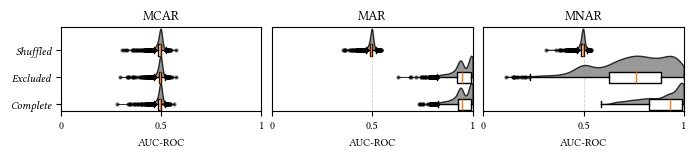

In [16]:
# Filter and rename
df_half_error = df_clean[df_clean['error_rate'] == 0.5].copy()

# Setup
error_mechanisms = ['MCAR', 'MAR', 'MNAR']  # fixed ordering
scenarios = sorted(df_half_error['scenario'].unique())

# Exact figure dimensions (in inches)
#  - ACM SIGCONF two‐column textwidth is 6.875in; 
#  - SIGCONF text‐block height is ~9.0in.
TW_double = 6.875
TW_single = 3.25
H8 = 9.0 / 6.0  # 1/6th of a page in height

fig, axes = plt.subplots(
    nrows=1, ncols=len(error_mechanisms),
    figsize= (TW_double, H8),
    sharex=True, sharey=False
)

if len(error_mechanisms) == 1:
    axes = [axes]

# Vertical spacing and y-tick positions
spacing = 0.4
y_positions = np.arange(len(scenarios)) * spacing * 0.6

for col_idx, mechanism in enumerate(error_mechanisms):
    subset = df_half_error[df_half_error['error_mechanism'] == mechanism]
    ax = axes[col_idx]

    # Add vertical gridline at x = 0.5
    ax.axvline(
        x=0.5,
        color='lightgray',
        linestyle='--',
        linewidth=0.6,
        zorder=0
    )

    for i, scenario in enumerate(scenarios):
        vals = subset.loc[subset['scenario'] == scenario, 'auc_roc']
        vp = ax.violinplot(
            vals,
            positions=[y_positions[i]],
            vert=False,
            widths=spacing * 0.95,
            showextrema=False
        )
        for body in vp['bodies']:
            body.set_facecolor('gray')
            body.set_edgecolor('black')
            body.set_alpha(0.8)

            # Clip the lower half
            clip_rect = mpl.patches.Rectangle(
                (0, y_positions[i]),
                1.0,
                spacing / 2,
                transform=ax.transData
            )
            body.set_clip_path(clip_rect)

        ax.boxplot(
            vals,
            positions=[y_positions[i]],
            vert=False,
            widths=spacing * 0.25,
            patch_artist=True,
            boxprops=dict(facecolor='white', edgecolor='black'),
            medianprops=dict(color='#ff7f0e'),
            flierprops={
                'marker': 'o',
                'markerfacecolor': 'black',
                'markeredgecolor': 'black',
                'markersize': 2,
                'alpha': 0.5
            }
        )

    if col_idx == 0:
        ax.set_yticks(y_positions)
        ax.set_yticklabels(scenarios)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    ax.set_xlim(0, 1)
    ax.set_xlabel('AUC-ROC')
    ax.set_title(mechanism)

    bottom = y_positions[0] - spacing / 7
    top = y_positions[-1] + spacing / 2
    ax.set_ylim(bottom, top)

    for label in ax.get_yticklabels():
        label.set_fontstyle('italic')

for ax in axes:
    ticks = [0.0, 0.5, 1.0]
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(custom_xtick_formatter_factory(ticks)))
    ax.tick_params(axis='x')
    ax.xaxis.set_minor_locator(mticker.NullLocator())

plt.tight_layout(pad=0.5)
plt.savefig("../plots/auc_roc_clean_violinplots.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

Dirty

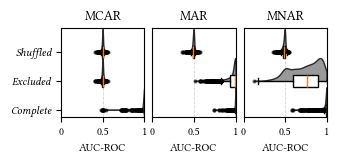

In [17]:
# Filter and rename
df_half_error = df_dirty[df_dirty['error_rate'] == 0.5].copy()


# Setup
error_mechanisms = ['MCAR', 'MAR', 'MNAR']  # fixed ordering
scenarios = sorted(df_half_error['scenario'].unique())

fig, axes = plt.subplots(
    nrows=1, ncols=len(error_mechanisms),
    figsize=(TW_single, H8),
    sharex=True, sharey=False
)

if len(error_mechanisms) == 1:
    axes = [axes]

# Vertical spacing and y-tick positions
spacing = 0.4
y_positions = np.arange(len(scenarios)) * spacing * 0.6

for col_idx, mechanism in enumerate(error_mechanisms):
    subset = df_half_error[df_half_error['error_mechanism'] == mechanism]
    ax = axes[col_idx]

    # Add vertical gridline at x = 0.5
    ax.axvline(
        x=0.5,
        color='lightgray',
        linestyle='--',
        linewidth=0.6,
        zorder=0
    )

    for i, scenario in enumerate(scenarios):
        vals = subset.loc[subset['scenario'] == scenario, 'auc_roc']
        vp = ax.violinplot(
            vals,
            positions=[y_positions[i]],
            vert=False,
            widths=spacing * 0.95,
            showextrema=False
        )
        for body in vp['bodies']:
            body.set_facecolor('gray')
            body.set_edgecolor('black')
            body.set_alpha(0.8)

            # Clip the lower half
            clip_rect = mpl.patches.Rectangle(
                (0, y_positions[i]),
                1.0,
                spacing / 2,
                transform=ax.transData
            )
            body.set_clip_path(clip_rect)

        ax.boxplot(
            vals,
            positions=[y_positions[i]],
            vert=False,
            widths=spacing * 0.25,
            patch_artist=True,
            boxprops=dict(facecolor='white', edgecolor='black'),
            medianprops=dict(color='#ff7f0e'),
            flierprops={
                'marker': 'o',
                'markerfacecolor': 'black',
                'markeredgecolor': 'black',
                'markersize': 2,
                'alpha': 0.5
            }
        )

    if col_idx == 0:
        ax.set_yticks(y_positions)
        ax.set_yticklabels(scenarios)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    ax.set_xlim(0, 1)
    ax.set_xlabel('AUC-ROC')
    ax.set_title(mechanism)

    bottom = y_positions[0] - spacing / 7
    top = y_positions[-1] + spacing / 2
    ax.set_ylim(bottom, top)

    for label in ax.get_yticklabels():
        label.set_fontstyle('italic')

for ax in axes:
    ticks = [0.0, 0.5, 1.0]  # Explicitly include the ticks you want
    ax.set_xticks(ticks)

    def smart_tick_formatter(x, pos):
        if x in (0.0, 1.0):
            return f"{int(x)}"
        elif x == 0.5:
            return f"{x:.1f}"
        else:
            return ""
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(smart_tick_formatter))
    ax.tick_params(axis='x')
    ax.xaxis.set_minor_locator(mticker.NullLocator())

plt.tight_layout(pad=0.25)
plt.savefig("../plots/auc_roc_dirty_violinplots.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

Clean data AUC-ROC boxplots for error rates 0.1, 0.25, 0.5, 0.75, 0.9

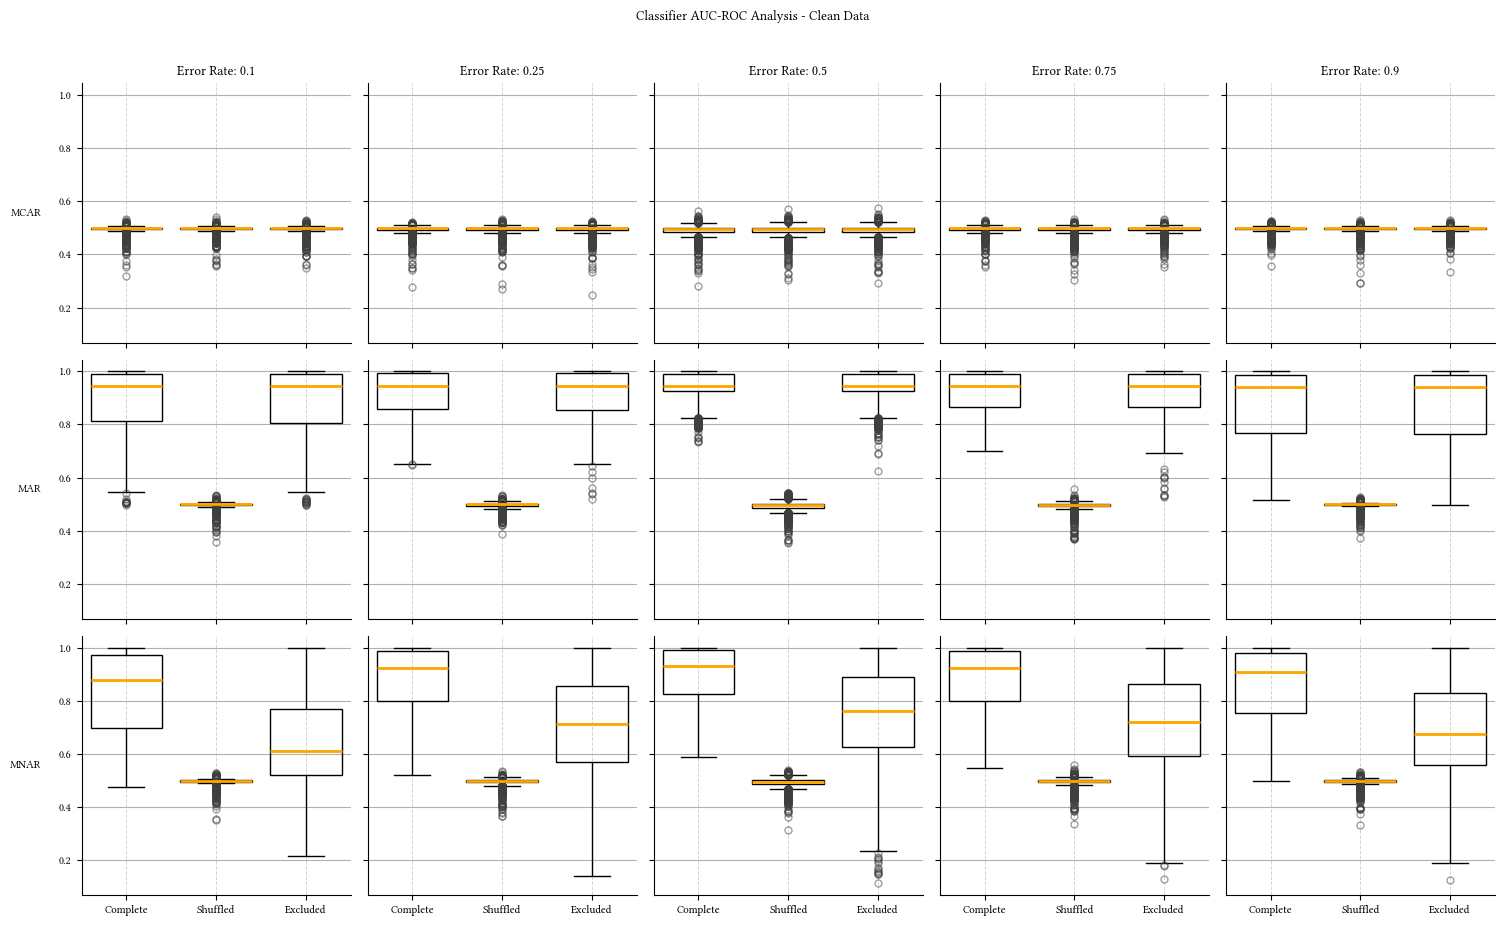

In [18]:
# Define boxplot style overrides
box_kws = {
    'boxprops': dict(facecolor='none', edgecolor='black'),
    'medianprops': dict(color='orange', linewidth=2),
    'whiskerprops': dict(color='black'),
    'capprops': dict(color='black'),
    'flierprops': dict(marker='o', color='gray', alpha=0.5),
}


# Catplot
g = sns.catplot(data=df_clean, x='scenario', y='auc_roc', row='error_mechanism', col='error_rate', kind='box', height=3, aspect=1, sharey=True, **box_kws)

# Remove the default row titles
for ax in g.axes.flatten():  # first column of axes in each row
    ax.set_title('')    # clear the title
    ax.set_xlabel('')
    
    # Add vertical grid lines
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.grid(True, axis='x', linestyle='--', color='lightgray', linewidth=0.7)

# Add custom y-label-like text on the left of each row
for i, ax in enumerate(g.axes[:,0]):
    # Place text centered vertically in the axes, a bit left of the y-axis
    ax.annotate(
        g.row_names[i],           # label text
        xy=(0, 0.5),              # coordinate in axes fraction (0 left, 0.5 center vertically)
        xycoords='axes fraction',
        ha='right', va='center',
        fontweight='bold',
        xytext=(-ax.yaxis.labelpad - 25, 0),
        textcoords='offset points'
    )
    ax.set_ylabel('')  # optionally clear default y-label

# Add custom column titles above top-row subplots
error_rates = [0.1, 0.25, 0.5, 0.75, 0.9]
for ax, title in zip(g.axes[0], error_rates):
    ax.set_title("Error Rate: " + str(title), fontweight='bold')

g.figure.suptitle('Classifier AUC-ROC Analysis - Clean Data', fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

Dirty data AUC-ROC boxplots for error rates 0.1, 0.25, 0.5, 0.75, 0.9

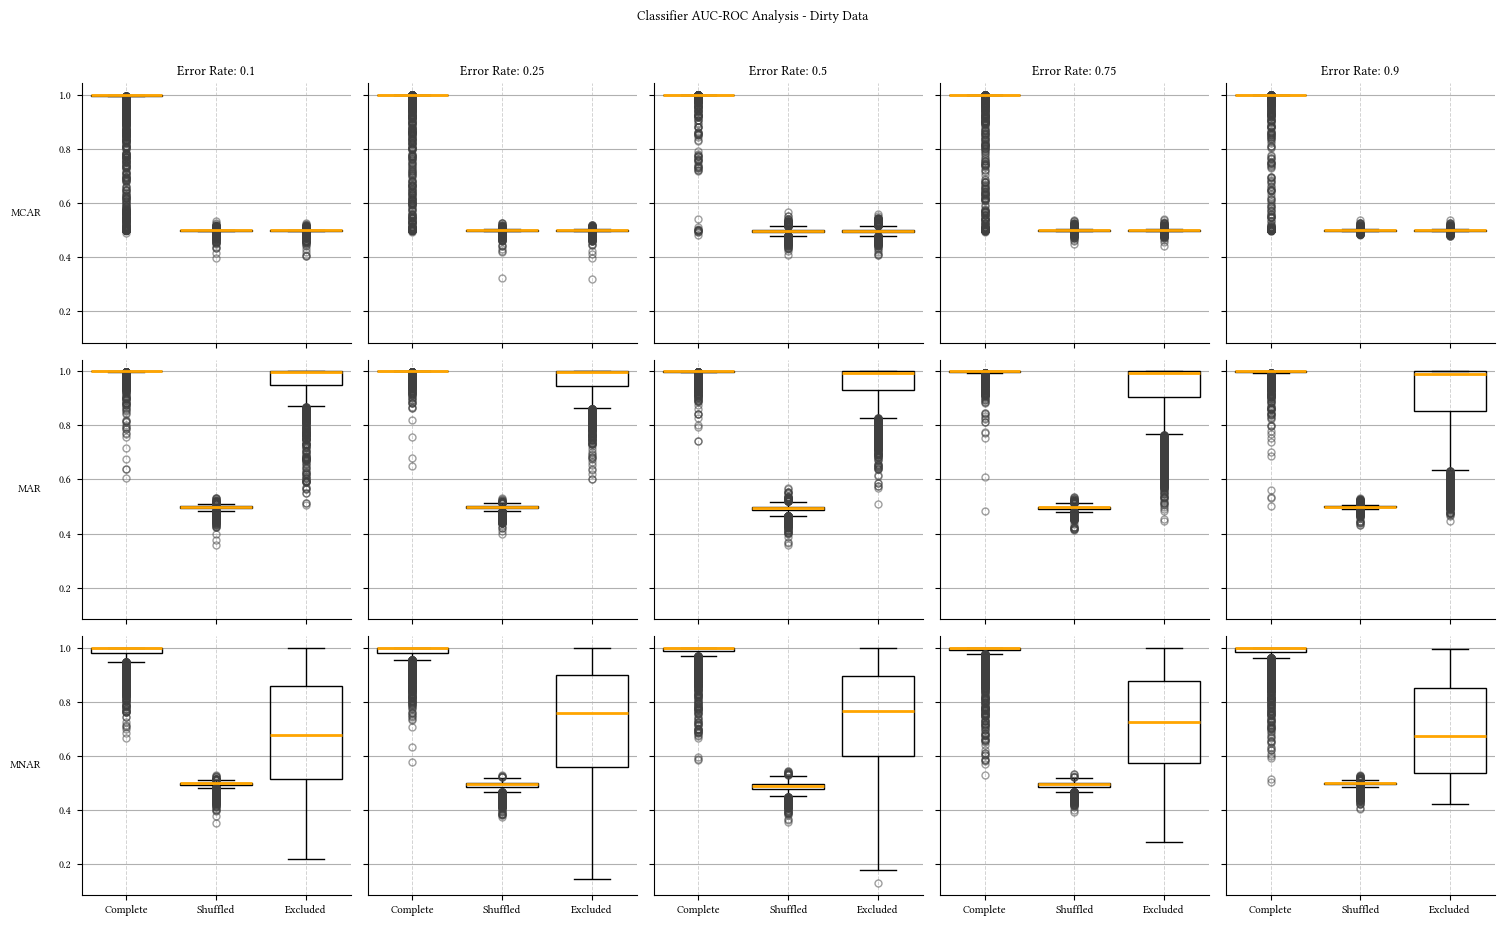

In [19]:
# Catplot
g = sns.catplot(data=df_dirty, x='scenario', y='auc_roc', row='error_mechanism', col='error_rate', kind='box', height=3, aspect=1, sharey=True, **box_kws)

# Remove the default row titles
for ax in g.axes.flatten():  # first column of axes in each row
    ax.set_title('')    # clear the title
    ax.set_xlabel('')

    # Add vertical grid lines
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.grid(True, axis='x', linestyle='--', color='lightgray', linewidth=0.7)

# Add custom y-label-like text on the left of each row
for i, ax in enumerate(g.axes[:,0]):
    # Place text centered vertically in the axes, a bit left of the y-axis
    ax.annotate(
        g.row_names[i],           # label text, e.g. 'ECAR'
        xy=(0, 0.5),              # coordinate in axes fraction (0 left, 0.5 center vertically)
        xycoords='axes fraction',
        ha='right', va='center',
        fontweight='bold',
        xytext=(-ax.yaxis.labelpad - 25, 0),
        textcoords='offset points'
    )
    ax.set_ylabel('')  # optionally clear default y-label

# Add custom column titles above top-row subplots
error_rates = [0.1, 0.25, 0.5, 0.75, 0.9]
for ax, title in zip(g.axes[0], error_rates):
    ax.set_title("Error Rate: " + str(title), fontweight='bold')

g.figure.suptitle('Classifier AUC-ROC Analysis - Dirty Data', fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()
